<a href="https://colab.research.google.com/github/danadler-dev/cellular_automata/blob/main/ca_grid_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<h1>Cellular Automata and Agent-Based Simulations on a Grid</h1>
<h4> Dan Adler - dan@danadler.com </h4>
</center>

Cellular Automata are an agent-based model of distributed computation where each agent looks at its closest neighbors and determines its next state based on some function of this neighborhood. We usually examine a 3x3 neighborhood where the agent is at the center and has 8 neighbors (9 including himself).

As the 3x3 window moves from agent to agent it computes its next state. There are various ways to handle the edges of the grid, sometimes with padding, and sometimes with wrap-around.

A similar idea has become popular in similar years in Machine Learning. Convolutional Neural Networks (CNN's) are a powerful tool in learning attributes of images as well as other applications.

A Convolution operator is well-known operator used in math, engineering and deep learning. This [video](https://www.youtube.com/watch?v=KuXjwB4LzSA) gives some good intuition on why convolution works, as does this [article](https://towardsdatascience.com/types-of-convolution-kernels-simplified-f040cb307c37) and many others.

In the following section I use numpy to create a 2-dimensional matrix. We then show that we can compute an averaging convolution 2 ways:

*   By computing, for each point (i,j) in the matrix, a square 3x3 matrix centered around (i,j). When we reach the edges, we use a wrap-around modulo operator (a more popular option is padding). Then we compute a mean operator over each vector of 9 neighbors.
*   By using the scipy.signl.convolve2d operator directly.

We will see that these two methods produce the same result:


In [1]:
import numpy as np
import scipy.signal
import scipy.stats
import itertools
from matplotlib import pyplot
import random
import imageio
import zlib
import math

Define a square neighborhood around each point in the 2D matrix returns a matrix of the same size, where each element is replaced by a vector of its neighbors (where the original element is first):

In [2]:

def neighbors(a):
  s = a.shape
  i,j = np.indices(s)
  around = list(itertools.product((0,-1,1), (0,-1,1))) # 9 neighbord including me at (0,0) with wraparound
  r = np.array([a[(i+n)%s[0],(j+m)%s[1]] for n,m in around])
  num = np.prod(r.shape)
  num_s = np.prod(s)
  xx = np.array([r.reshape(num)[i::num_s] for i in range(num_s)])
  yy = xx.reshape(s[0],s[1],len(around))
  return yy

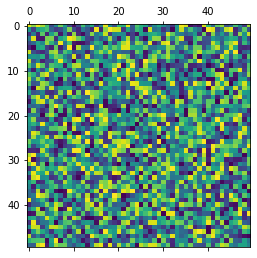

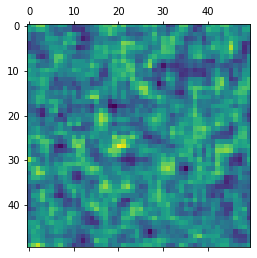

In [3]:
N = 50
# create a NxN random matrix
x = np.reshape(np.random.random(N*N), (N,N))
pyplot.matshow(x)
# find its neighborhoods
n = neighbors(x)
# calculate the mean of each point and its neighbors
y = np.mean(n,axis=2)
pyplot.matshow(y)

Now calculate the same thing using a 3x3 convolution kernel. Since it has 9 cells, giving each one a weight of 1/9 will produce a mean across the 9 neighbors (including self):

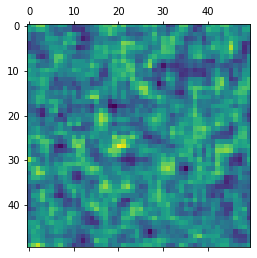

In [4]:
kernel = np.reshape(np.array([1/9]*9), (3,3))
y = scipy.signal.convolve2d(x,kernel,boundary='wrap',mode='same')
pyplot.matshow(y)

A more realistic example would be to read in an image and then perform the convolution. In this case, the averaging operation results in blurring, but in many machine learning applications, different kernels are used for edge detection and other feature extractions. Also, in this example we are supplying the weights for the kernel, whereas in CNN the weights are learned from the sample data.

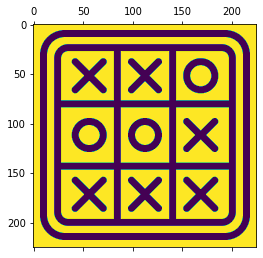

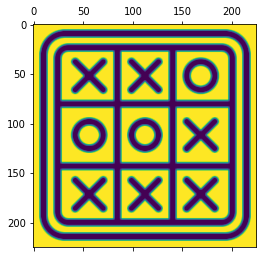

In [5]:
x = imageio.imread('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSbOLpAbsXj4dYY76itOmwCHa5MJCMu_-W5HQ&usqp=CAU') / 255
pyplot.matshow(x)
kernel = np.reshape(np.array([1/9]*9), (3,3))
y = scipy.signal.convolve2d(x,kernel,boundary='wrap',mode='same')
pyplot.matshow(y)

While the convolve2d function is faster and more concise, computing the neighborhood explictly allows us to create filters that are not linear combinations. For example, multiplying all the values in the neighborhood:

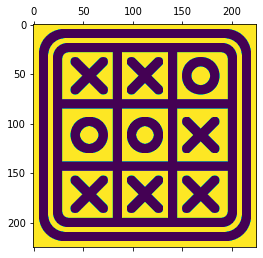

In [6]:
n = neighbors(x)
pyplot.matshow(np.prod(n, axis=2))

<H2> One Dimensional Cellular Automata</H2>

Cellular Automata are a great tool for demonstrating that high-level visual patterns can arise from simple low-level rules, where each cell sets its next state based on its current state and the state of its local neighbors. This is what it's called an Automaton. It implements a simple state machine. Each cell implements the same rule, and the emergent patterns are surprisingly comples, and often periodic in unexpected ways. In One Dimensional CA's, cells only examine their own current state, and the current state of their left and right neighbors (ignoring above and below). So each cell examines a self-inclusive 3 cell neighborhood.

Although we are using 2-Dimensional neighborhoods, the code above puts its self, left and right cells in the first 3 slots, so we can use array slicing to implement 1-dimensional Cellular Automata as shown at wolframscience.com:
<img width="1000" src="https://www.wolframscience.com/nks/pages/p24--how-do-simple-programs-behave/image-xlarge.png">

The first rule above is implemented in the following code snippet. We are only showing the 1st row of the matrix in each plot, as this is a 1D example. The pattern emerges through the successive evolution of the 1D array when viewed as a single image. 

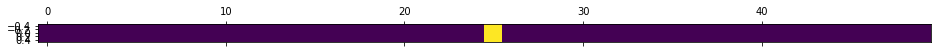

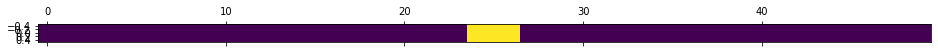

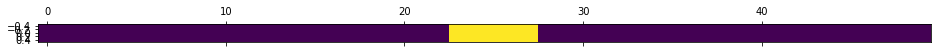

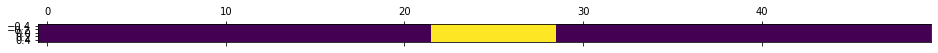

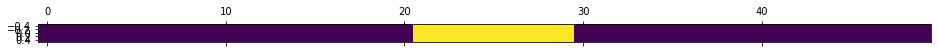

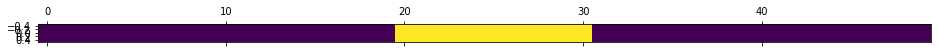

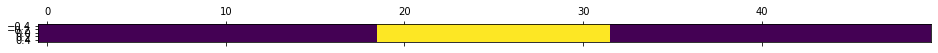

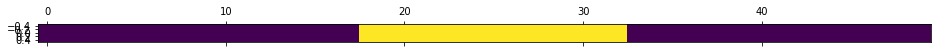

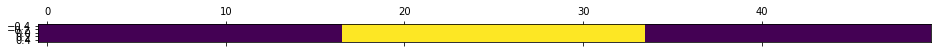

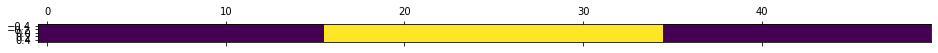

In [7]:
N = 50
# create a NxN matrix of zeros with a 1 in the middle of the 1st row
x0 = np.reshape(np.zeros(N*N, dtype=np.uint8), (N,N))
x0[0, int(N/2)] = 1
x = x0
NM = 10
for i in range(NM):
  pyplot.matshow(x[0:1])
  n = neighbors(x)
  # Only check left,self,right neighbors
  x = np.any(n[:,:,0:3], axis=2)

The two images in the following page are reproduced by the two following code segments.
<img width="1000" src="https://www.wolframscience.com/nks/pages/p25--how-do-simple-programs-behave/image-xlarge.png"/>

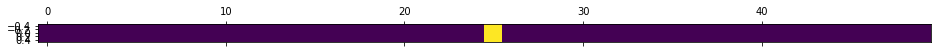

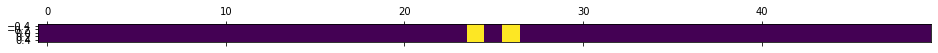

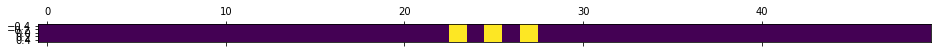

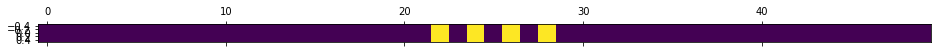

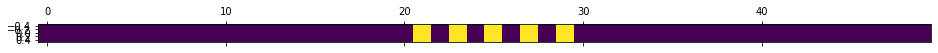

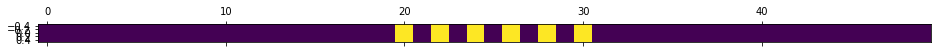

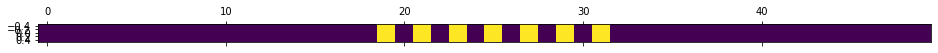

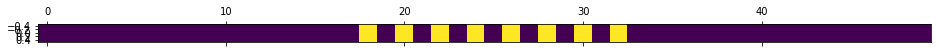

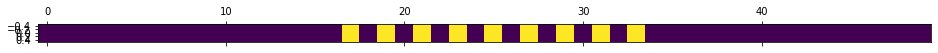

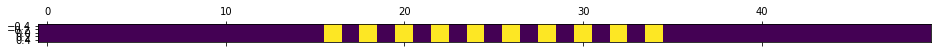

In [8]:
x = x0
#for i in range(int(N/2)):
for i in range(10):
  pyplot.matshow(x[0:1])
  n = neighbors(x)
  # Only check left,right neighbors
  s = n[:,:,(1,2)]
  x = np.any(s, axis=2)

The following rule is a slight variation. If either but not both of my neighbors are True. This produces some interesting emergent patterns.

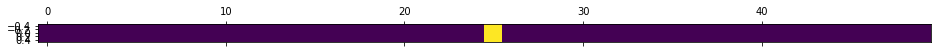

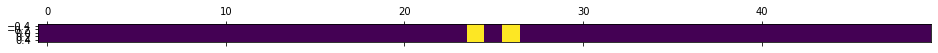

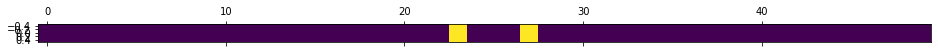

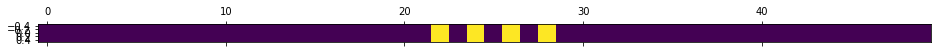

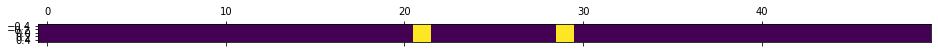

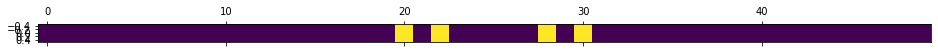

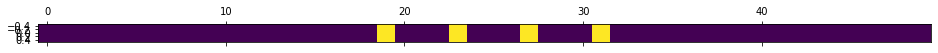

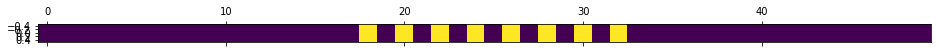

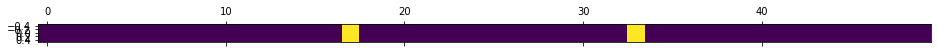

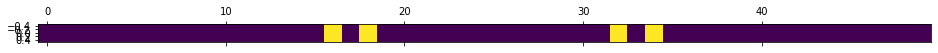

In [9]:
x = x0
#for i in range(int(N/2)):
for i in range(10):
  pyplot.matshow(x[0:1])
  n = neighbors(x)
  # Only check left,right neighbors
  s = n[:,:,(1,2)]
  x = np.any(s, axis=2) & ~np.all(s, axis=2)

<H2> Two Dimensional Cellular Automata</H2>

Two dimensional CA's are handled in Chapter 5 of Wolfram. In this case, cells determine their next state based on simple rules that examine their whole self-inclusive neighborhood of 9.

<img width="1000" src="https://www.wolframscience.com/nks/pages/p171--cellular-automata/image-xlarge.png" />

The first example is shown below (any of my 4 neighbors or myself is 1):

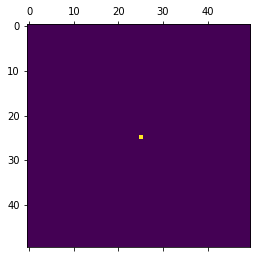

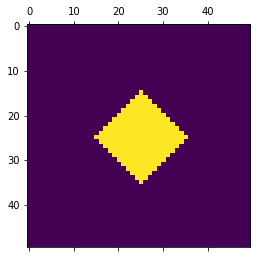

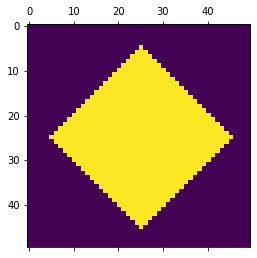

In [10]:
N = 50
# create a NxN matrix of zeros with a 1 in the middle
x0 = np.reshape(np.zeros(N*N, dtype=np.uint8), (N,N))
x0[int(N/2), int(N/2)] = 1
x = x0
for i in range(30):
  if i%10 == 0: pyplot.matshow(x)
  n = neighbors(x)
  # Only check left,right,up, down neighbors
  s = n[:,:,(0,1,2,3,6)]
  x = np.any(s, axis=2)

In the following example we use the rule of any and not all of the 4 neighbors:

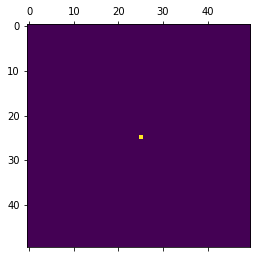

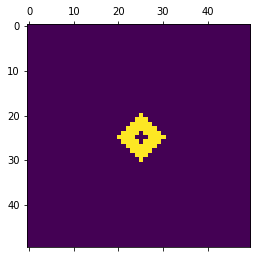

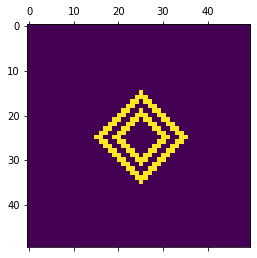

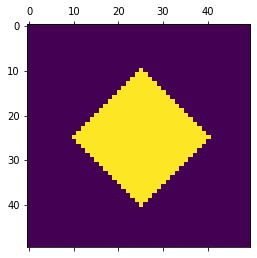

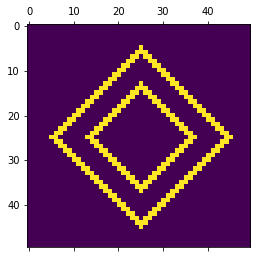

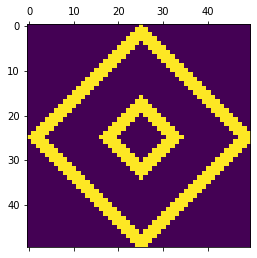

In [11]:
x = x0
for i in range(30):
  if i%5 == 0: pyplot.matshow(x)
  n = neighbors(x)
  # Only check left,right,up, down neighbors
  s = n[:,:,(0,1,2,3,6)]
  x = np.any(s, axis=2) & ~np.all(s, axis=2)

In the following example I look at all my 9 neighbors (including myself) and set to 1 if any but not all are 1. This produces a surprising sequence of concentric squares that don't have an obvious periodicity.

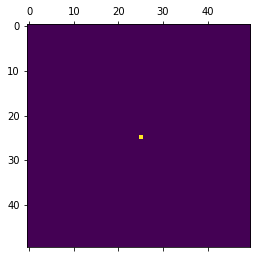

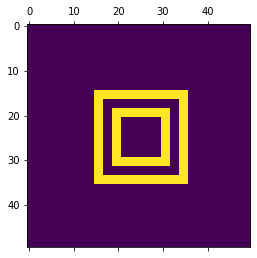

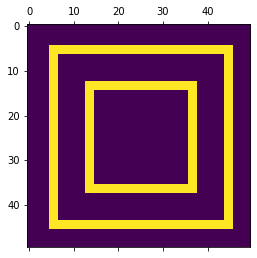

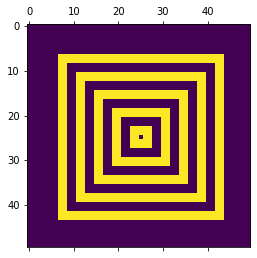

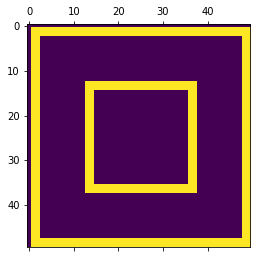

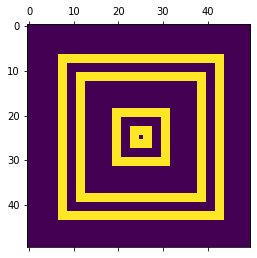

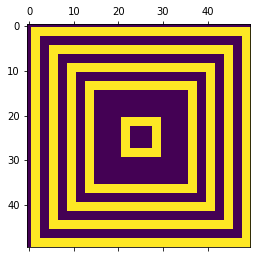

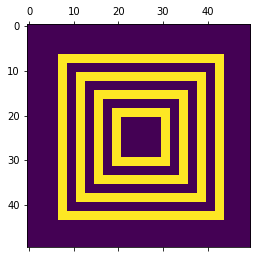

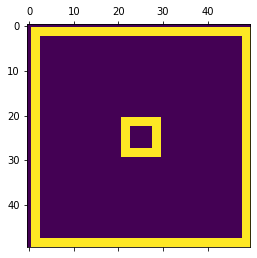

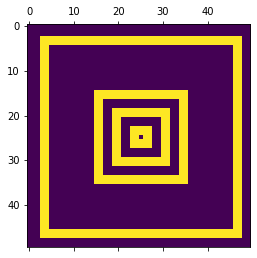

In [12]:
x = x0
for i in range(100):
  if i%10 == 0: pyplot.matshow(x)
  n = neighbors(x)
  x = np.any(n, axis=2) & ~np.all(n, axis=2)

<H2>The Game of Life</H2>

The Game of Life, also known simply as Life, is a cellular automaton devised by the British mathematician John Horton Conway in 1970. It is a zero-player game meaning that its evolution is determined by its initial state, requiring no further input. One interacts with the Game of Life by creating an initial configuration and observing how it evolves. It is Turing complete and can simulate a universal constructor or any other Turing machine.

The rules for the Game of Life are summarized [here](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life):

* Any live cell with two or three live neighbours survives.
* Any dead cell with three live neighbours becomes a live cell.
* All other live cells die in the next generation. Similarly, all other dead cells stay dead.

These rules are implemented below using the exact same neighbors() code we have used in the Cellular Automata examples.

The only difference is that we now have two rules which we implement as s1 and s2 below, and then s1|s2 represents the bitwise or of the conditions. Rule s1 checks that my cell is alive (1) and I have 2-3 live neighbors, and rule s2 checks that I have exactly 3 live neighbors. The logical or of these two rules implements the Game Of Life rules shown above.


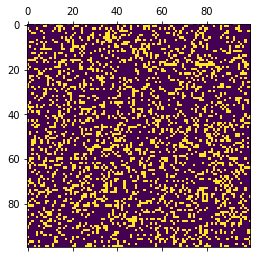

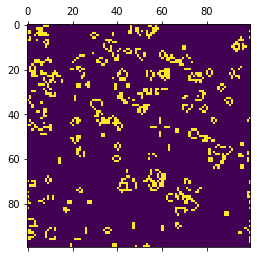

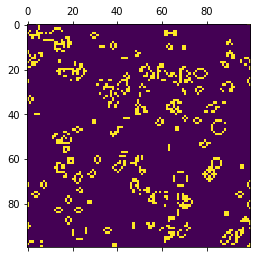

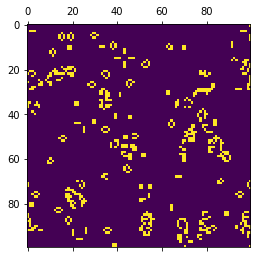

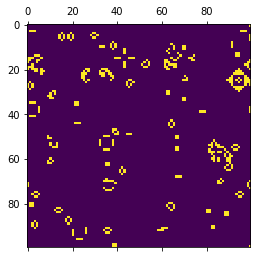

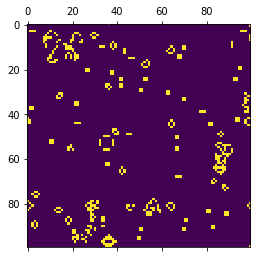

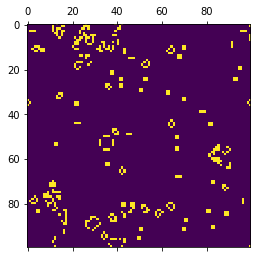

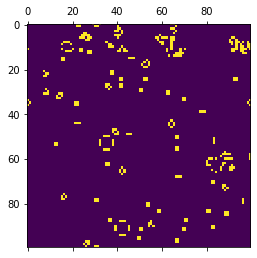

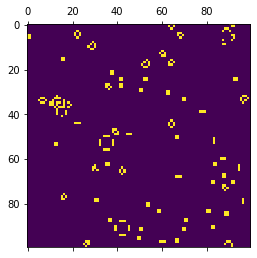

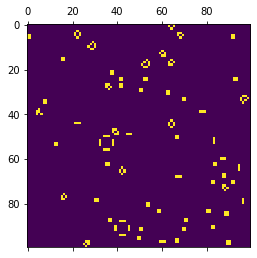

In [13]:
N = 100
p = 0.25
# create a NxN matrix of zeros with p% random 1's
x0 = np.random.choice(a=[False, True], size=(N, N), p=[1-p,p])
x = x0
NT = 1000
for i in range(NT):
  if i%(int(NT/10)) == 0: pyplot.matshow(x)
  n = neighbors(x)
  s1 = np.isin(np.sum(n[:,:,1:9], axis=2), (2,3)) & np.any(n[:,:,(0,)], axis=2) # I'm alive and I have 2-3 live neighbors
  s2 = np.isin(np.sum(n[:,:,1:9], axis=2), (3,)) # I have 3 live neighbors
  x = s1|s2

<H2>Schelling's Model of Segregation</H2>


[Thomas Schelling](https://en.wikipedia.org/wiki/Schelling%27s_model_of_segregation) wrote a famous [paper](https://www.uzh.ch/cmsssl/suz/dam/jcr:00000000-68cb-72db-ffff-ffffff8071db/04.02%7B_%7Dschelling%7B_%7D71.pdf) in 1971 where he defined a simple dynamic rule as follows: if you have a group of 1's and 0's in the matrix, each one examins its neighbors and stays if there are at least 0 <= N <= 8 neighbors having the same value as them. So, if N is 2 then each 0 will want to find two other 0's in his 8 neighbors. Shelling, who was a sociologist, argued that this kind of modest preference can cause segregation of minority communities such as immigrant or racial communities.

The following loop is almost identical to the Game of Life above. We start with 20% (p = 0.2) True's and 80% False's randomly. Then we apply the rule: if I have 2-9 True neighbors and I am True, then I stay True. Otherwise, I move to a random new spot. I implement the moving by counting how many True's turned to False's and then inserting that many True's in random locations.

For this combination of parameters, we can see the True's forming their own "neighborhoods".

I Calculate an isolation score of a configuration using the [scipy.ndimage.measurements.lable](https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.ndimage.measurements.label.html) function which labels connected components. Then the isolation is the number of components. So, fewer components means less isolation, i.e. more of the 1's are in contiguous regions. 

In [85]:
import scipy.ndimage.measurements
def isolation(x):
  s = [[1,1,1],
       [1,1,1],
       [1,1,1]]
  return scipy.ndimage.measurements.label(x, structure=s)[1]

Isolation before: 728
simulation steady after: 18
Isolation after: 136


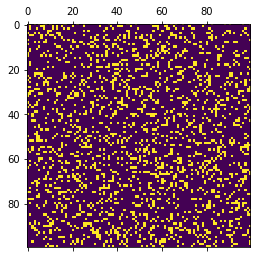

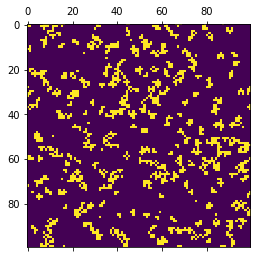

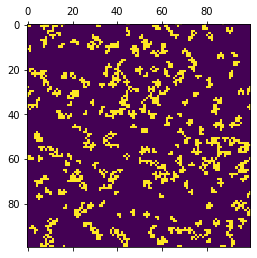

In [86]:
N = 100
p = 0.2
# create a NxN matrix of zeros with p% random 1's
x0 = np.random.choice(a=[False, True], size=(N, N), p=[1-p,p])
x = x0
print('Isolation before:', isolation(x))
NT = 1000
for i in range(NT):
  if i%(int(10)) == 0: pyplot.matshow(x)
  n = neighbors(x)
  x1 = np.isin(np.sum(n[:,:,1:9], axis=2), (2,3,4,5,6,7,8)) & np.any(n[:,:,(0,)], axis=2)
  n_new = np.sum(x & ~x1) # people who moved - place them randomly
  if n_new == 0:
    # If no one moves, we are done
    print('simulation steady after:', i)
    pyplot.matshow(x)
    break
  for j in range(n_new):
    n = random.randint(0,N-1)
    m = random.randint(0,N-1)
    x1[n,m] = True
  x = x1
print('Isolation after:', isolation(x))

<H2>Random Boolean Networks</H2>

A [Boolean network](https://en.wikipedia.org/wiki/Boolean_network) is a particular kind of sequential dynamical system, where time and states are discrete, i.e. both the set of variables and the set of states in the time series each have a bijection onto an integer series.

A random Boolean network (RBN) is one that is randomly selected from the set of all possible boolean networks of a particular size, N. One then can study statistically, how the expected properties of such networks depend on various statistical properties of the ensemble of all possible networks. For example, one may study how the RBN behavior changes as the average connectivity is changed.

The first Boolean networks were proposed by Stuart A. Kauffman in 1969, as random models of genetic regulatory networks.

We can model random boolean networks using the same boolean cellular grid we used for the other examples. 

As in the cellular automata case, a cell's state is determined by the state of its 8 neighbors (ignoring the cell's prior state). However, in this case we will interpret the function cell = f(i[0],i[1]..i[7]) as ordered binary digits, and since there are 8 neighbors their binary state can be represented as an 8-bit number between 0 and 255. So, we can express the function f() above simply as a set of integers in the range [0,255]. For example, the set [2,17] or [all even numbers between 0 and 256]. Each of these define a different boolean network with different dynamics.

In the following example, we assume all cells perform the same logical truth table on their inputs. 

In more general cases, people have defined random boolean networks that have different boolean truth functions at different cells, and where cell inputs can be distant, not just immediate neighbors.

The interpretation of this function is that of a truth table. For example, the following truth table is equivalent to: [1,3,255] as these are the only input combinations that result in an output of 1 (all others are 0).

<table>
  <tr><th>Inputs</th><th>Output</th></tr>
  <tr><td>0,0,0,0,0,0,0,1</td><td>1</td></tr>
  <tr><td>0,0,0,0,0,0,1,1</td><td>1</td></tr>
  <tr><td>...</td><td>0</td></tr>
  <tr><td>...</td><td>0</td></tr>
  <tr><td>1,1,1,1,1,1,1,1</td><td>1</td></tr>
</table>


As you can see in the examples below, some result in patches that are oriented in a particular direction. One reason is that some of the values tend to ignore the top-right or bottom-left or other neighbor, so it appears as a directional element.

I calculate a before and after compressibility measure to see if the information content (which is proportional to entropy) went down. If the result is more compressible, then it has more order and lower entropy.

Isolation before: 490
Isolation after: 419


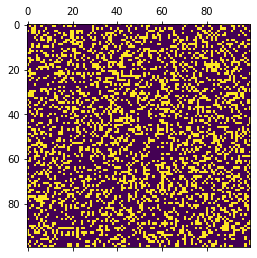

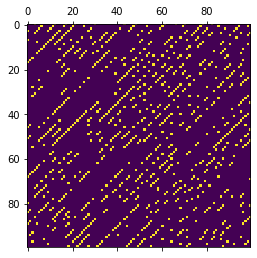

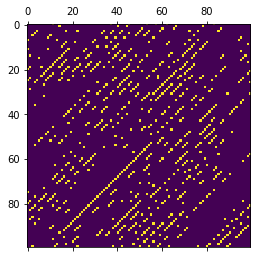

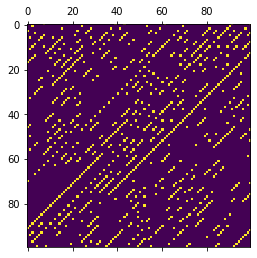

In [87]:
def boolean_network(num, prob, sim_len, values, fig=True, init=None):
  # create a NxN matrix of zeros with p% random 1's
  if init is None:
    x0 = np.random.choice(a=[False, True], size=(num, num), p=[1-prob,prob])
  else:
    x0 = init
  x = x0
  if (fig): print('Isolation before:', isolation(x))
  for i in range(sim_len):
    if fig and (i%50 == 0): pyplot.matshow(x)
    n = neighbors(x)
    x1 = np.isin(np.packbits(n[:,:,1:9], axis=2), values)
    x1.shape = (num, num)
    if np.array_equal(x, x1):
      if fig: print('static after:', i)
      break
    x = x1
  c = isolation(x)
  if fig: print('Isolation after:', c)
  else: return c

values = [x for x in range(4,256,15)]
boolean_network(100, 0.3, 200, values)

A different set of allowed values for the 8 neighbors produces a very different dynamic behavior. one (0<n<256 that divide by 20) produces larger patches that seem to be oriented downward: 

Isolation before: 496
Isolation after: 148


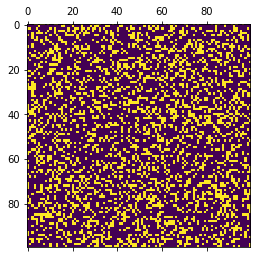

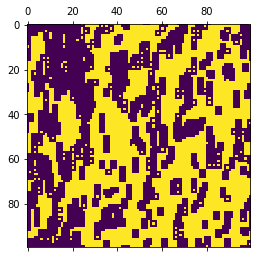

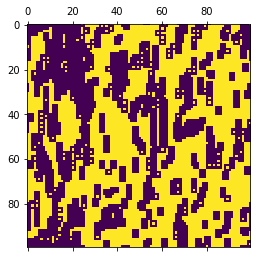

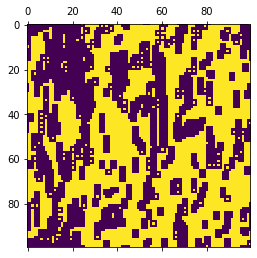

In [88]:
values = [x for x in range(0,256,20)]
boolean_network(100, 0.3, 200, values)


A different set of allowed values for the 8 neighbors produces a very different dynamic behavior. one (0<n<256 that are odd starting from 3) produces thinner patches that seem to be oriented down and to the right: 

Isolation before: 489
Isolation after: 189


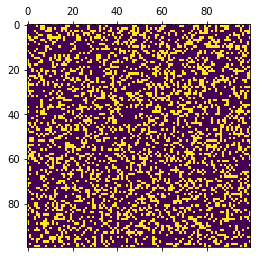

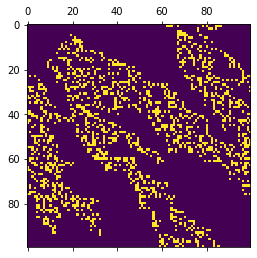

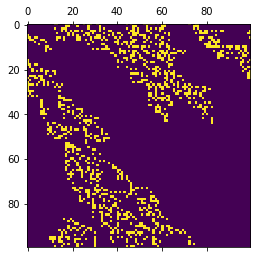

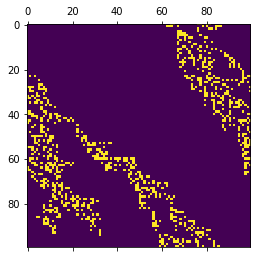

In [89]:
values = [x for x in range(3,256,2)]
boolean_network(100, 0.3, 200, values)

<H2> Conclusions </H2>

I have shown how 2-dimensional numpy arrays (matrices) together with a neighbors(x) function, which expands 3x3 neighborhoods around each value, allows me to use fast vectorized operations to implement a wide array of examples: Convolution, Cellular Automata, Game of Life, Shelling's model, and Random Boolean Networks.
